In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import random
from tensorflow import keras

/Users/sam/tensor/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [6]:
data_dir='/Users/sam/tensor/screenshots_big'

img_height=48
img_width=48
batch_size=32


In [9]:
#从具有相同标签名的图片中 分出100个放入测试集 用于评估模型效果
image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith('.png')]
labels = [os.path.splitext(os.path.basename(p))[0] for p in image_paths] 

labels = [label.split('_')[1] for label in labels]

unique_label = set()

train_path_label = []
validate_path_label = []



for i in range(len(labels)):
    path = image_paths[i]
    label = labels[i]
    if label not in unique_label:
        train_path_label.append((path,label))
        unique_label.add(label)
    else:
       validate_path_label.append((path,label)) 






random.shuffle(validate_path_label)
valid_100 = validate_path_label[:100]
train_path_label.extend(validate_path_label[100:]) #剩下的放回训练集 



print(f'path {len(train_path_label)} label {len(unique_label)} train {len(valid_100)}')
for path, label in valid_100:
    print(path, label)






path 18945 label 4223 train 100
/Users/sam/tensor/screenshots_big/13157_vaccines.png vaccines
/Users/sam/tensor/screenshots_big/12713_heat_pump.png heat
/Users/sam/tensor/screenshots_big/14396_refresh.png refresh
/Users/sam/tensor/screenshots_big/9605_bot-message-square.png bot-message-square
/Users/sam/tensor/screenshots_big/10219_mic.png mic
/Users/sam/tensor/screenshots_big/7873_calendar_month.png calendar
/Users/sam/tensor/screenshots_big/11530_arrow_back.png arrow
/Users/sam/tensor/screenshots_big/13943_compress.png compress
/Users/sam/tensor/screenshots_big/13963_escalator_warning.png escalator
/Users/sam/tensor/screenshots_big/12329_start.png start
/Users/sam/tensor/screenshots_big/5786_skateboarding.png skateboarding
/Users/sam/tensor/screenshots_big/3766_calendar-xmark.png calendar-xmark
/Users/sam/tensor/screenshots_big/11053_hourglass-half.png hourglass-half
/Users/sam/tensor/screenshots_big/2579_square-lastfm.png square-lastfm
/Users/sam/tensor/screenshots_big/425_monitor.p

In [10]:
#对标签进行编码
label_names = unique_label
label_to_index = {name: idx for idx, name in enumerate(label_names)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

label_encoded = [label_to_index[label] for _, label in  train_path_label]

print(label_encoded[:10])



[1339, 1801, 3159, 2803, 3267, 1378, 766, 2296, 2658, 2605]


In [11]:
#png是四通道的 
def rgba_to_rgb(rgba, background=(255, 255, 255)):
    """
    将RGBA转换为RGB，使用指定背景色混合透明区域
    
    参数:
    rgba: RGBA张量 (uint8, 形状 [H, W, 4])
    background: 背景颜色 (R, G, B) 元组 (0-255)
    
    返回:
    RGB张量 (uint8, 形状 [H, W, 3])
    """
    # 分离通道
    rgb = rgba[..., :3]
    alpha = rgba[..., 3:]
    
    # 转换为float32进行混合计算
    rgb = tf.cast(rgb, tf.float32)
    alpha = tf.cast(alpha, tf.float32) / 255.0  # 归一化到[0,1]
    
    # 创建背景张量
    bg = tf.ones_like(rgb) * tf.constant(background, dtype=tf.float32)
    
    # 混合公式: 前景 * alpha + 背景 * (1 - alpha)
    blended = rgb * alpha + bg * (1.0 - alpha)
    
    # 转换回uint8
    return tf.cast(blended, tf.uint8)

def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)#white
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.rgb_to_grayscale(image) 
    image = tf.cast(image, tf.float32) / 255.0
    return image, label




In [12]:
train_paths = [path for path, _ in  train_path_label]

print(len(train_paths), len(label_encoded))

path_ds = tf.data.Dataset.from_tensor_slices((train_paths, label_encoded))
image_label_ds = path_ds.map(load_and_preprocess_image)
dataset = image_label_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
                                                    
images, labels_encoded = zip(*list(image_label_ds.as_numpy_iterator()))

images_tensor = tf.convert_to_tensor(images, dtype=tf.float32)


print(images_tensor.shape)

18945 18945


2025-06-10 22:05:24.852184: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-06-10 22:05:24.852208: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-06-10 22:05:24.852212: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
2025-06-10 22:05:24.852229: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-10 22:05:24.852238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-06-10 22:05:26.454220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(18945, 48, 48, 1)


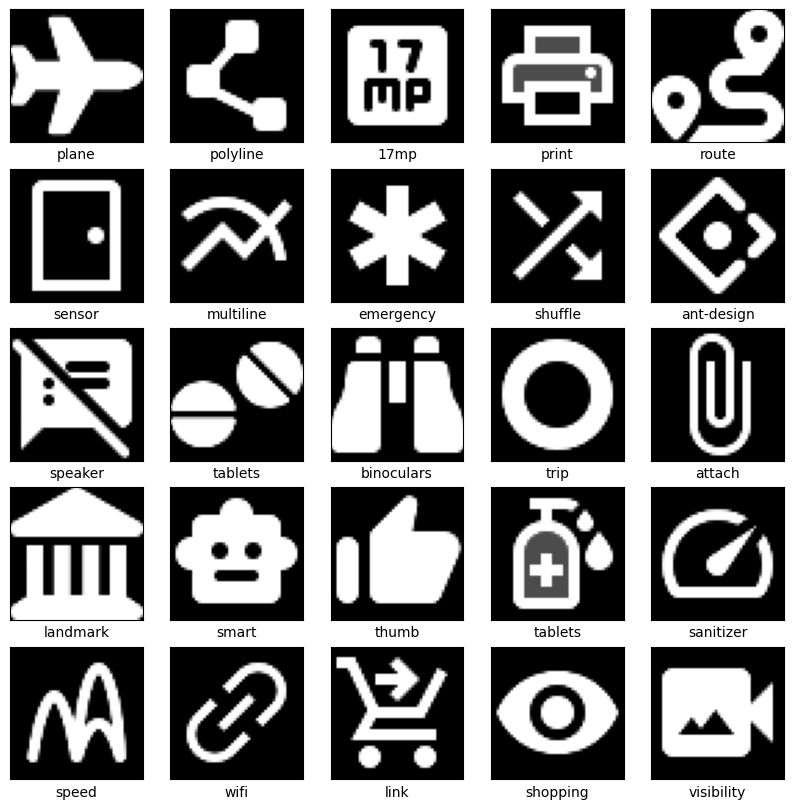

In [13]:

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_tensor[i], cmap=plt.cm.binary)
    plt.xlabel(labels[i])
plt.show()  # (num_images, 50, 50, 3)



In [14]:
num_classes=len(label_names)
model = tf.keras.Sequential([
    # 输入层
    tf.keras.layers.Input(shape=(img_height, img_width, 1)),
    
    # 第一个卷积块
    tf.keras.layers.Conv2D(32, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(32, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    # 第二个卷积块
    tf.keras.layers.Conv2D(64, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(64, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    # 第三个卷积块
    tf.keras.layers.Conv2D(128, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Conv2D(128, 3, padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),
    
    # 全连接层
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# 使用Adam优化器，添加学习率衰减
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 128)    │             

 Total params: 4,816,479 (18.37 MB)

 Trainable params: 4,814,559 (18.37 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [15]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, acc=0.95):
        super().__init__()
        self.acc = acc

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') is not None and logs.get('accuracy') >= self.acc:
            print(f"\n达到{self.acc*100:.2f}%准确率，停止训练。")
            self.model.stop_training = True


#训练达到90%准确率时停止
history = model.fit(dataset, epochs=30, callbacks=[MyThresholdCallback(acc=0.95)])

Epoch 1/30


2025-06-10 22:08:51.571912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


593/593 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.0311 - loss: 7.9944
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.1566 - loss: 5.5108
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.3407 - loss: 3.5667
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.5285 - loss: 2.1684
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.6848 - loss: 1.3471
Epoch 6/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.7501 - loss: 0.9976
Epoch 7/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8061 - loss: 0.7512
Epoch 8/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8395 - loss: 0.5900
Epoch 9/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8611 - loss: 0.5138
Epoch 10/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8836 - loss: 0.4135
Epoch 11/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8934 - loss: 0.3661
Epoch 12/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 

In [20]:
#记录模型
model_save_path = '/Users/sam/tensor/saved_model.keras'
model.save(model_save_path)


In [ ]:
# 加载模型
loaded_model = tf.keras.models.load_model(model_save_path)

593/593 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


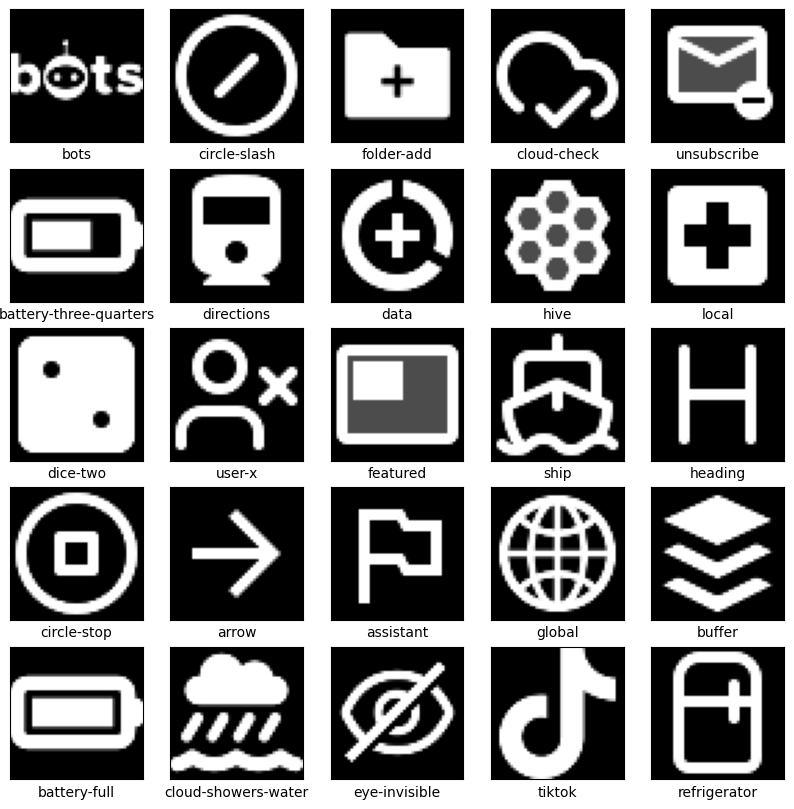

In [17]:
#在训练数据上验证

predictions = model.predict(images_tensor)

plt.figure(figsize=(10,10))
for i in range(25):
    predicted_label = np.argmax(predictions[i+25])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_tensor[i+25], cmap=plt.cm.binary)
    plt.xlabel(index_to_label[predicted_label])
plt.show() 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


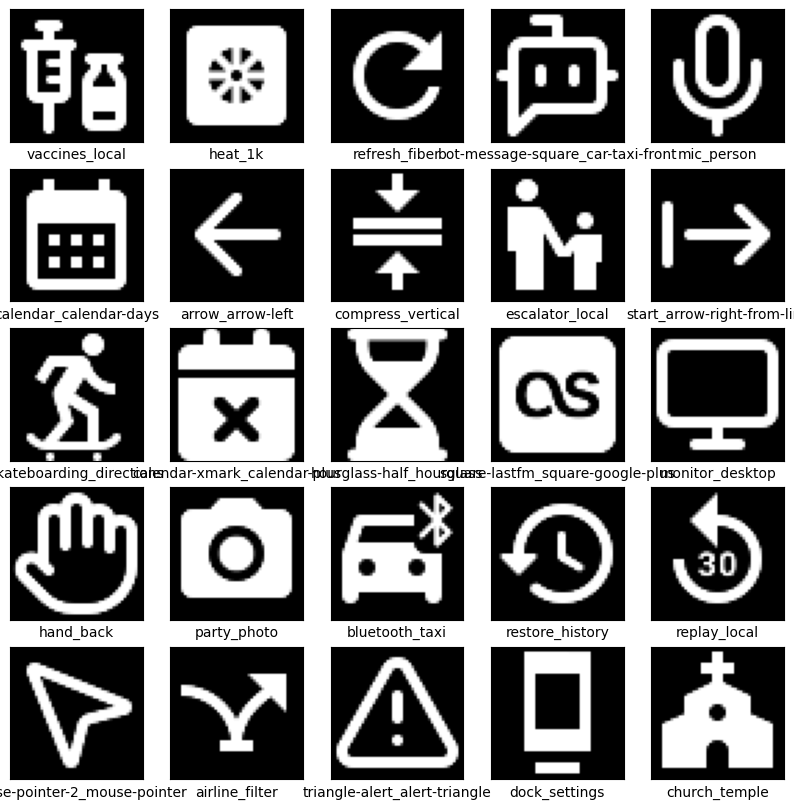

In [21]:
#在测试数据上验证
def load_and_preprocess_test_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.rgb_to_grayscale(image) 
    image = tf.cast(image, tf.float32) / 255.0
    return image

test_paths = [path for path, label in valid_100]
test_path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_image_ds = test_path_ds.map(load_and_preprocess_test_image)
test_image_ds = test_image_ds.batch(32)

predictions = model.predict(test_image_ds)

plt.figure(figsize=(10,10))
cnt = 25
for i in range(cnt):
    image = tf.io.read_file(test_paths[i])
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.rgb_to_grayscale(image) 
    s = np.argsort(predictions[i])
    first = s[-1]
    second = s[-2]
    predicted_label = np.argmax(predictions[i])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    label = f'{index_to_label[first]}_{index_to_label[second]}'
    plt.xlabel(label)
plt.show()

['/Users/sam/tensor/test/add.png', '/Users/sam/tensor/test/check.png', '/Users/sam/tensor/test/toggle_on_50dp_000000_FILL0_wght400_GRAD0_opsz48.png', '/Users/sam/tensor/test/delete_24dp_000000_FILL0_wght400_GRAD0_opsz24.png', '/Users/sam/tensor/test/chevron_right.png']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


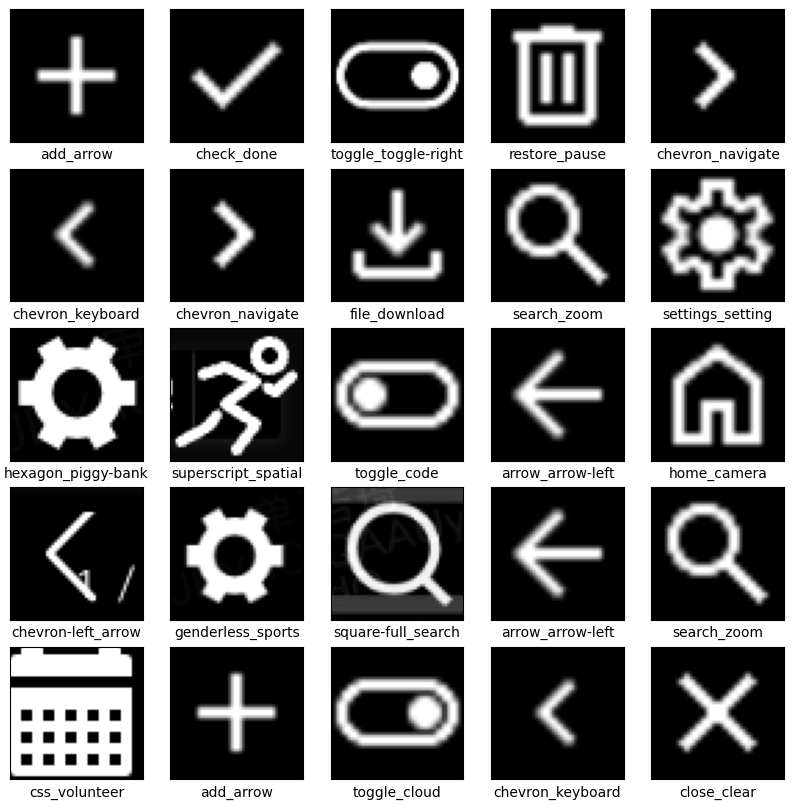

In [65]:


#测试数据
test_dir='/Users/sam/tensor/test'
test_paths = [os.path.join(test_dir, fname) for fname in os.listdir(test_dir) if fname.endswith('.png')]
#test_paths=['/Users/rockyshan/icon_tf/test/search.png', '/Users/rockyshan/icon_tf/test/config.png', '/Users/rockyshan/icon_tf/test/arrow.png','/Users/rockyshan/icon_tf/test/setting1.png']

print(test_paths[0:5])
def load_and_preprocess_test_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.rgb_to_grayscale(image) 
    image = tf.cast(image, tf.float32) / 255.0
    return image



test_path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
test_image_ds = test_path_ds.map(load_and_preprocess_test_image)
test_image_ds = test_image_ds.batch(32)

predictions = model.predict(test_image_ds)

plt.figure(figsize=(10,10))
cnt = len(test_paths)
for i in range(25):
    image = tf.io.read_file(test_paths[i])
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.rgb_to_grayscale(image) 
    s = np.argsort(predictions[i])
    first = s[-1]
    second = s[-2]
    predicted_label = np.argmax(predictions[i])
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    label = f'{index_to_label[first]}_{index_to_label[second]}'
    #label=index_to_label[predicted_label]
    plt.xlabel(label)
plt.show()

<Figure size 1000x1000 with 0 Axes>

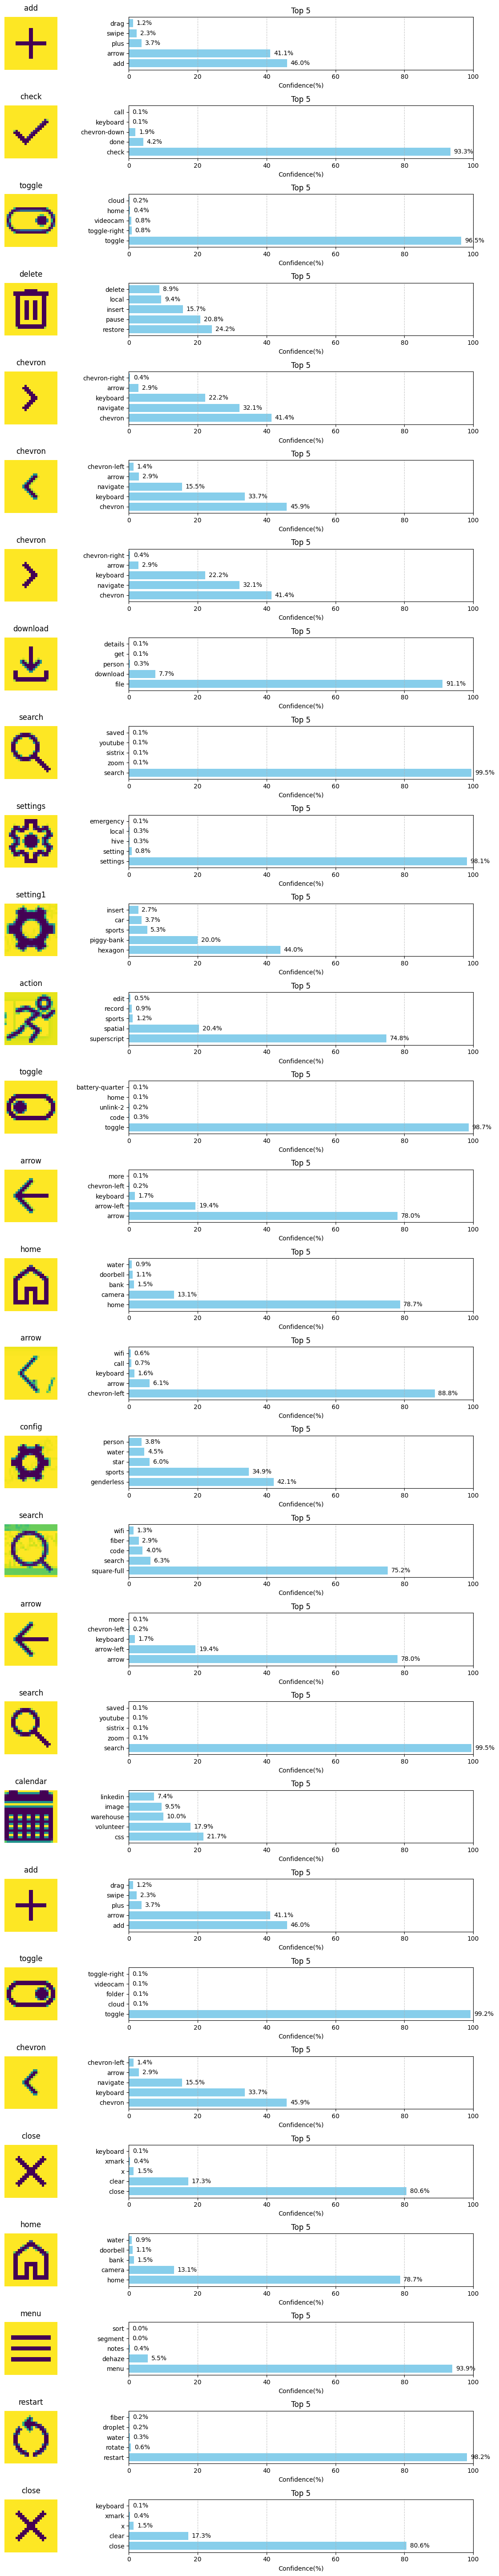

In [69]:


def plot_value_array(ax_bar, predictions_array):
    # 清除之前的图形
    ax_bar.clear()
    
    # 获取前5个最高预测值
    sorted_indices = np.argsort(predictions_array)
    top5_indices = sorted_indices[-5:][::-1]  # 反转顺序，从高到低
    
    # 准备数据
    values = predictions_array[top5_indices] * 100  # 转换为百分比
    labels = [index_to_label[i] for i in top5_indices]
    
    # 设置柱状图
    bars = ax_bar.barh(labels, values, color='skyblue')
    
    # 设置坐标轴
    ax_bar.set_xlim(0, 100)  # 设置x轴范围为0-100
    ax_bar.set_xticks(np.arange(0, 101, 20))  # 设置x轴刻度
    ax_bar.set_xlabel('Confidence(%)')
    
    # 在柱状图上添加数值标签
    for bar in bars:
        width = bar.get_width()
        ax_bar.text(width + 1, bar.get_y() + bar.get_height()/2,
                   f'{width:.1f}%',
                   ha='left', va='center')
    
    # 设置网格
    ax_bar.grid(True, axis='x', linestyle='--', alpha=0.7)
    
    # 移除y轴刻度
    #ax_bar.set_yticks([])
    
    # 设置标题
    ax_bar.set_title('Top 5')
  
  
  


plt.figure(figsize=(10,10))

num_rows = len(test_paths)
#num_rows = 2
fig, axes = plt.subplots(num_rows, 2, 
                         figsize=(12, 2 * num_rows),
                         gridspec_kw={'width_ratios': [1, 3]})  # 主图:柱状图 = 1:3

# 遍历每一行
for row in range(num_rows):
    # --- 绘制主图（左侧）---
    ax_img = axes[row, 0] 
    image = tf.io.read_file(test_paths[row])
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    image = tf.image.resize(image, [24, 24])
    image = tf.image.rgb_to_grayscale(image) 
    ax_img.imshow(image)
    ax_img.set_title(f"{os.path.splitext(os.path.basename(test_paths[row]))[0].split('_')[0]}", pad=10)
    ax_img.axis('off')  # 隐藏坐标轴

    # --- 绘制柱状图（右侧）---
    ax_bar = axes[row, 1] 
    plot_value_array(ax_bar, predictions[row])
    #ax_bar.axis('off')  # 隐藏坐标轴

# 调整布局
plt.tight_layout()
plt.show()

In [58]:
def load_test_data(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=4)
    image = rgba_to_rgb(image)
    image = tf.image.resize(image, [img_height, img_width])
    image = tf.image.rgb_to_grayscale(image) 
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

test_paths = [path for path, _ in valid_100]
test_label_encoded = [label_to_index[label] for _,label in valid_100]
test_path_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_label_encoded))
test_image_ds = test_path_ds.map(load_test_data)
test_image_ds = test_image_ds.batch(32)


test_loss, test_acc = model.evaluate(test_image_ds, verbose=2)

4/4 - 0s - 15ms/step - accuracy: 0.9500 - loss: 0.1694
